# USAGE EXAMPLES FOR SIMPLESEDML

This notebook provides examples of using ``SimpleSBML``.

The initial emphasize is on time course simulations. A ``SingleModelTimeCourse`` object has one required parameter, the model. This can be an Antimony or SBML string or file or a URL. There are optional parameters related to the simulation and changing values of the paramters of the model. It has the following methods:
* ``getSEDML``
* ``getPhraSEDML``
* ``execute``: returns a ``DataFrame`` and a plot of the variables specified in the constructor.

A ``MultipleModelTimeCourseObject`` has the same arguments as for ``SingleModelTimeCourse`` except that the one required argument is a list of models. It has the same methods as well. The only difference is that there is one plot for each variable specified in the constructor with a curve for each model.

Some use cases are:
1. Iteratively develop SEDML by use execute, and then generate desired SEDML.
2. Generate PhraSEDML, edit it, and then generate SEDML from these edits.

In [1]:
try:
    from simple_sedml import SimpleSEDML
except:
    !pip install SimpleSEDML
    from simple_sedml import SimpleSEDML
import pandas as pd
import constants as cn

/Users/jlheller/home/Technical/repos/SimpleSEDML/ssed/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Model

In [2]:
MODEL_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1
end
'''

In [3]:
MODEL2_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S1; k3*S3
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1
    k3 = 0.1
end
'''

# Use Case 1: Single model with default arguments

In [4]:
smtc = SimpleSEDML.makeSingleModelTimeCourse(MODEL_ANT, title="My Plot")

**Model saved to /Users/jlheller/home/Technical/repos/SimpleSEDML/examples/time_course_model


In [5]:
print(smtc.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="time_course_model" language="urn:sedml:language:sbml.level-3.version-2" source="/Users/jlheller/home/Technical/repos/SimpleSEDML/examples/time_course_model"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="time_course_sim" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="10">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="time_course_task" modelReference="time_course_model" simulationReference="time_course_sim"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="report_0_0_0" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time </ci>


We can also look at the PhraSED-ML that gets generated by changing the object that gets returned.

In [6]:
print(smtc.getPhraSEDML())

time_course_model = model "/Users/jlheller/home/Technical/repos/SimpleSEDML/examples/time_course_model" 
time_course_sim = simulate uniform(0, 5, 10)
time_course_sim.algorithm = CVODE
time_course_task = run time_course_sim on time_course_model
report "My Plot" time, S1, S2, S3
plot "My Plot" time vs S1, S2, S3


And we can execute the SEDML, getting both a plot and a DataFrame of time course values.

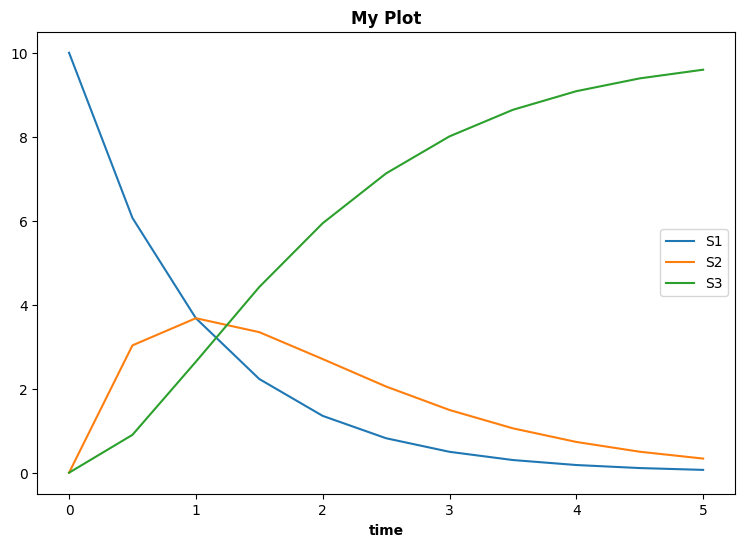

In [7]:
df = smtc.execute()

In [8]:
df.head()

,time,S1,S2,S3
0,0.0,10.000000,0.000000,0.000000
1,0.5,6.065307,3.032649,0.902044
2,1.0,3.678798,3.678777,2.642426
3,1.5,2.231306,3.346933,4.421761
4,2.0,1.353357,2.706690,5.939953


# Use Case 2: Single model with non-default arguments

In [9]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"

**Model saved to /Users/jlheller/home/Technical/repos/SimpleSEDML/examples/time_course_model


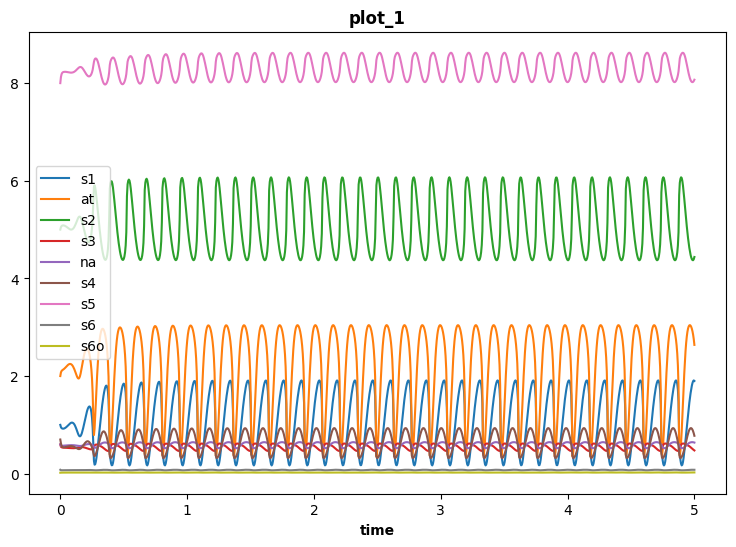

In [10]:
smtc = SimpleSEDML.makeSingleModelTimeCourse(WOLF_URL, num_point=1000)
_ = smtc.execute()

In [11]:
SimpleSEDML.getModelInformation(WOLF_URL)

**Model saved to /Users/jlheller/home/Technical/repos/SimpleSEDML/examples/dummy


Model: Wolf2000_Glycolytic_Oscillations
Parameters: {'k0': 50.0, 'k1': 550.0, 'k2': 9.8, 'k31': 323.8, 'k33': 57823.1, 'k32': 76411.1, 'k34': 23.7, 'k4': 80.0, 'k5': 9.7, 'k6': 2000.0, 'k7': 28.0, 'k8': 85.7, 'k9': 80.0, 'k10': 375.0, 'atot': 4.0, 'ntot': 1.0, 'n': 4.0, 'ki': 1.0}
Floating Species: {'s1': 1.0, 'at': 2.0, 's2': 5.0, 's3': 0.6, 'na': 0.6, 's4': 0.7, 's5': 8.0, 's6': 0.08, 's6o': 0.02}
Boundary Species: {}
Number of Reactions: 11
Number of Species: 9

**Model saved to /Users/jlheller/home/Technical/repos/SimpleSEDML/examples/time_course_model


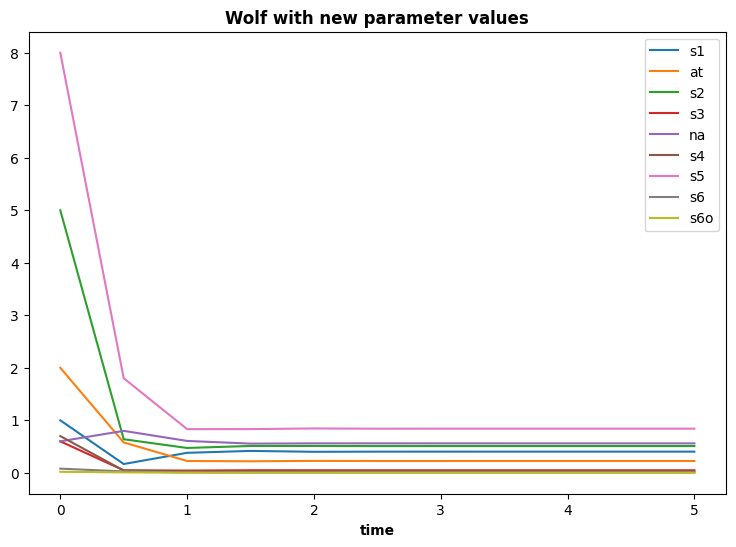

In [12]:
smtc = SimpleSEDML.makeSingleModelTimeCourse(WOLF_URL, k0=5, k1=55, title="Wolf with new parameter values")
df = smtc.execute()

In [13]:
df.head()

,time,s1,at,s2,s3,na,s4,s5,s6,s6o
0,0.0,1.000000,2.000000,5.000000,0.600000,0.600000,0.700000,8.000000,0.080000,0.020000
1,0.5,0.167970,0.579162,0.639675,0.047800,0.799205,0.043673,1.801447,0.026906,0.008861
2,1.0,0.381272,0.225642,0.473636,0.042924,0.607620,0.025901,0.832152,0.007774,0.002500
3,1.5,0.417602,0.220384,0.511794,0.049333,0.556435,0.026954,0.832856,0.007070,0.002255
4,2.0,0.400847,0.227533,0.511717,0.049070,0.561399,0.027128,0.845115,0.007238,0.002310


# Use Case 3: Comparing the time course simulation of multiple models

When comparing the time course simulation of multiple models, we want to compare selected **display variables** from the models, either in plots or in a DataFrame. The resulting ``MultipleModelTimeCourse`` object has the methods:
* ``getSEDML``
* ``getPhraSEDML``
* ``execute``

In [14]:
mmtc = SimpleSEDML.makeMultipleTimeCourseSimulation([MODEL_ANT, MODEL2_ANT])
mmtc.execute()

AttributeError: type object 'SimpleSEDML' has no attribute 'makeMultipleTimeCourseSimulation'

# Under construction: Compare several parameters at steady state for a single model

# Under construction: Compare stochastic simulations

# Under construction: Get data for several different simulations

In [ ]:
# Compose an experiment
ssed = SimpleSEDML()
ssed.addModel("model1", MODEL_ANT, k1=3, ref_type="ant_str", is_overwrite=True)
ssed.addSimulation("sim1", "uniform", start=0, end=1, num_step=50)
ssed.addTask("task1", "model1", "sim1")
ssed.addReport("time", "S1", "S2", "S3")
ssed.addPlot("time", "S2", title="my plot")

In [ ]:
# Run the descript
df = ssed.execute()

In [ ]:
df.head(10)

In [ ]:
ssed.getAllModelInformation()

# Under construction: Repeated Tasks

At present, the Tellurium execution of SED-ML only provides access to the last report for repeated tasks.

In [ ]:
# Make DataFrame of changes to model parameters
parameter_df = pd.DataFrame(dict(k1=[1, 3], k2=[1, 3]))

In [ ]:
ssed = SimpleSEDML()
ssed.addModel("model1", MODEL_ANT, k1=3, ref_type="ant_str", is_overwrite=True)
ssed.addSimulation("sim1", "uniform", start=0, end=1, num_step=50)
ssed.addTask("task1", "model1", "sim1")
ssed.addRepeatedTask("repeated_task1", "task1", parameter_df=parameter_df)
ssed.addReport("task1.time", "task1.S1", "task1.S2", "task1.S3")
ssed.addPlot("repeated_task1.time", "repeated_task1.S2", title="my plot")
result_df = ssed.execute()

In [ ]:
print(ssed.getSEDML())

# Cleanup

In [ ]:
import os
for ffile in ["model1", "myModel"]:
    if os.path.isfile(ffile):
        os.remove(ffile)